In [1]:
!nvidia-smi

Tue Oct  7 13:58:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P8              2W /  140W |    1094MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)


HOME: /home/mak/PycharmProjects/SegEdge


In [3]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [4]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"/home/mak/PycharmProjects/SegEdge/Models/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [17]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)


In [25]:
IMAGE_PATH = f"/home/mak/Downloads/super_small_sa.jpg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sam2_result = mask_generator.generate(image_rgb)

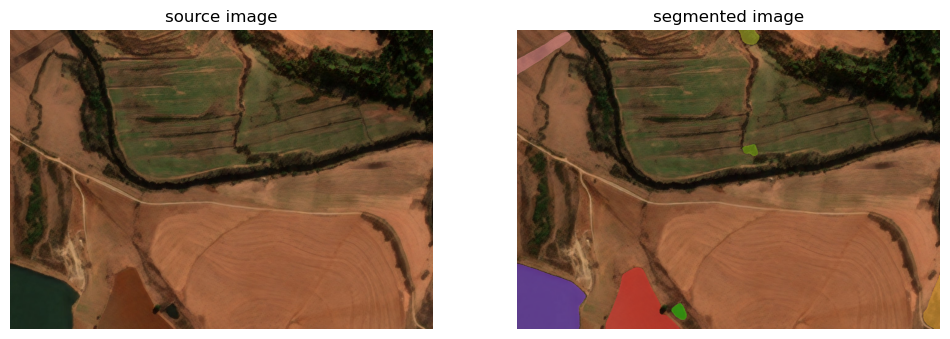

In [26]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [45]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=32,
    pred_iou_thresh=0.3,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    min_mask_region_area=1000
)
sam2_result_2 = mask_generator_2.generate(image_rgb)

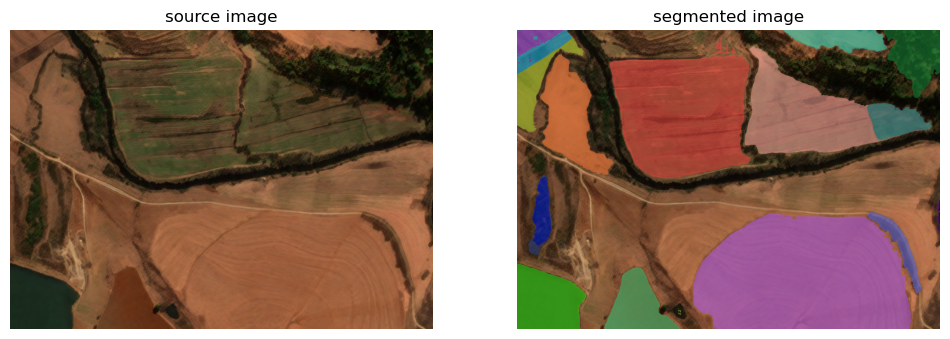

In [47]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [48]:
#test different configs
points_per_side = list(range(8, 128, 8))
points_per_batch = [4, 8, 16, 32]
pred_iou_thresh = [0.1, 0.2, 0.3, 0.4, 0.5]
stability_score_thresh = [0.7 , 0.8, 0.9 , 0.92, 0.95, 0.98]
stability_score_offset = [0.5, 0.6 , 0.7, 0.8]

n_combinations = len(points_per_side) * len(points_per_batch) * len(pred_iou_thresh) * len(stability_score_thresh) * len(stability_score_offset)
print(f"Total combinations to test: {n_combinations}")



Total combinations to test: 7200
